# EMG Signal Processing for Prosthetic Finger Control
***
A fundamental component of many modern prostheses is the myoelectric control system, which uses the Electromyogram (EMG) signals from an individual’s muscles to control the prosthesis movements.

This code will give a starting point for study of EMG signals.<br>

<b>The data used is given [here](https://www.rami-khushaba.com/biosignals-repository). It can be found under the title "Detecting Individual and Combined finger movements"</b>


<div class="alert alert-block alert-info">
<b>Point to Note:</b> <br> Download the data first, and copy this file to that folder. Keep the other files given by the name of <b>getfTDDfeat_v2.py</b> and <b>feature_extraction_TD_AR_Hjorth_without_window.py</b> in the same folder as this file to work with this default code. Otherwise you can make changes in the code accordingly
</div>

In [3]:
#This block of code will import all the necessary modules required for this project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split

#Custom module available on github. Link is provided below
import getfTDDfeat_v2 as ftdd

#Custom module made by the author for this project.
import feature_extraction_TD_AR_Hjorth_without_window as feat_extract

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import label_binarize

import tensorflow as tf
import keras
from keras.utils import to_categorical


<br>

## 1. Data Processing

<div class="alert alert-block alert-info">
<b>Point to Note:</b> <br>
        The following piece of code runs through all the files given in the folder <b>EMG_2Chs</b>. The folder <b>EMG-S3</b> and <b>EMG-S7</b> are excluded because they were excluded from the original research paper as well. To give a fare comparison, 8 class classification is used only.  
</div>

In [ ]:
integer_list = [1,2,4,5,6,8,9,10] #3 and 7 are excluded.
merged_df = {}

for i in integer_list:
    folder_path = f'EMG_2Chs/EMG-S{i}' #Change this folder path if the downloaded data and this code is not in the same folder
    file_list = glob.glob(f'{folder_path}/*')
    df_list = []
    for file in file_list:
        df = pd.read_csv(file, header=None)
        df_list.append(df)
    merged_df[f'merged_df_{i}'] = pd.concat(df_list, axis=1)
    merged_df[f'merged_df_{i}'] = merged_df[f'merged_df_{i}'].T #Transpose is done to make it a 120*20001 matrix.

In [8]:
#This code merges all those individual keys in one large 960*20001 dataframe

all_dfs = [df for key, df in merged_df.items()]

final_df = pd.concat(all_dfs, axis=0)

In [9]:
#This piece of code will export the dataframe to a csv file

final_df.to_csv('Whole_merged_data_set_2Chs.csv', index=False)

<div class="alert alert-block alert-warning">
<b>Little insight into the data:</b> <br><br>
Now that you have downloaded all the data and merged into a dataframe and also exported it into a csv file, let us dive into some details of the data. <br> <br>
If you have gone through the materials downloaded, you will know that the data is taken from a surface electrode and there are 2 channels in it. So in the individual file there are $ 20000 $ rows and $ 2 $ columns. There are $ 60 $ samples for each group. We have taken $ 8 $ classes. So that makes it $ 2*60*8 = 960 $ columns and $ 20000 $ rows. It has been transposed, so the resultant is a 960*20000 matrix. 
<br> <br>What about the output? There are 8 classes. First 120 values belongs to Class-1, next 120 belongs to Class-2 and so on. We will run a loop to get the output class after the feature extraction step. The feature extraction not only reduce the 20000 samples but also reduce the number of rows. That is because 2 channel data is used to extract feautures for a single traning example. So finally the training examples will be $ 960/2 = 480 $. 
<br> <br> The code is so designed that you can also use the code for training an EMG Signal with n number of channels.  
</div>

In [10]:
#Read the file. No need to run the above code repeatedly once you export as a csv file

df = pd.read_csv('Whole_merged_data_set_2Chs.csv') 

<br>

<br>

## 2. Algorithm fTDD+PCA+SVM/ANN

In the first algorithm, the feature is extracted via the Fused Time Domain Descriptors procedure(fTDD). The code for this process available [here](https://github.com/RamiKhushaba/getfTDDfeatures) in github. The mathematical details of the procedure can be found [here](https://pdfs.semanticscholar.org/4730/98af39c66b0a4b541860a1f4617c036d8249.pdf). After feature extraction, the feature is reduced via Principal Component Analysis(PCA). Then it is trained via SVM and ANN.

<div class="alert alert-block alert-warning">
<b>Calcuation used in the next block:</b> <br><br>
A 2D array of $ 480 $ rows and $ 12*95 $ columns is initiated first. Calcuation of 480 is given below. Since two channels are taken for a single training example. Now, coming to the important part. <br><br> Why 12*95? First go through the fTDD paper hyperlinked above. You will understand that it uses windows and also fuses windows at last. I have taken window size as $ 400 $ and window overlap as $ 200 $. The number of windows formed is given by the formula <br><br>
    $$ Window formed =  \frac{(Data length - window size)}{window increment} + 1 $$<br>
Putting the values used here we get, <br>
    $$ Window formed = \frac{(20000 - 400)}{200} + 1 = 99 $$ <br>
Now the windows are fused. Each 4th window is multiplied (Given by the steps used. We have used 4. See the code where I have called getfTDDfeat_v2). That means 1st window features is multiplied with the 4th window to get a resultant 1st window. Similarily 2nd window is multiplied by 5th and so finally we are left with $ 99 - 4 = 95 $ windows. <br><br> So for one sample we have created a 95*12 matrix as a training data. To use it as a feature vector, we have flattened the layer to form a vector of length $ 95*12 = 1140 $   
</div>

<div class="alert alert-block alert-info">
<b>Point to Note:</b> <br>
You can play with the window size, overlap and step. But do not forget to change the size of the numpy array initiated in the first line. Do the calculation like the above block. If you are using some other data with n number of channels you have to give that many rows to via the code <b>df.iloc[[i,i+1]]</b>. You will also have to change the $ 12 $ initiated in the zeros then. 
</div>

<br>

### 2a) fTDD and preparation of the data

In [18]:
#This piece of block will create the data to train and feature extraction

X_data = np.zeros((480,12*95))
j = 0

for i in range(0,960,2):
    x = df.iloc[[i,i+1]].T
    feat = ftdd.getfTDDfeat_v2(x, 4, 400, 200)
    X_data[j] = feat.flatten()
    j += 1

In [19]:
#This piece of block will fix the output data. 

y_data = []

for i in range(1,9):
    for j in range(0,60):
        y_data.append(i) 

y_data= np.array(y_data)

<br>

### 2b) Principal Component Analysis(PCA)

In [24]:
#Does the PCA. 

pca = PCA(n_components = 0.95) #0.95 is taken as the number of components will explain that much of variance.
X_data_reduced = pca.fit_transform(X_data)

In [25]:
#Compare the size of the X_data with X_data_reduced

print("Shape of X_data is:", X_data.shape)
print("Shape of X_data_reduced is:", X_data_reduced.shape)

Shape of X_data is: (480, 1140)
Shape of X_data_reduced is: (480, 20)


<div class="alert alert-block alert-info">
<b>Point to Note:</b> <br>
The new reduced matrix loses its physical significance. The 12 features taken from fTDD has some physical significance. But since PCA projects the data along completely different axes, the data has now lost its physical significance.<br>The 1140 values is reduced to 20 and that 20 values is enough to explain 95% of the variance. That implies the similarity of the data. That is why PCA can be such a valuable algorithm in such cases. 
</div>

<br>

### 2c) Classification Algorithms

#### 2c i)Support Vector Machine(SVM)

In [26]:
#Create a test set with 20% of the data

X_train, X_test, y_train, y_test = train_test_split(X_data_reduced, y_data, test_size = 0.2, random_state = 42)

In [27]:
#Train on training data
svm = SVC()
svm.fit(X_train, y_train)

# Predict on validation data
y_val_pred = svm.predict(X_test)


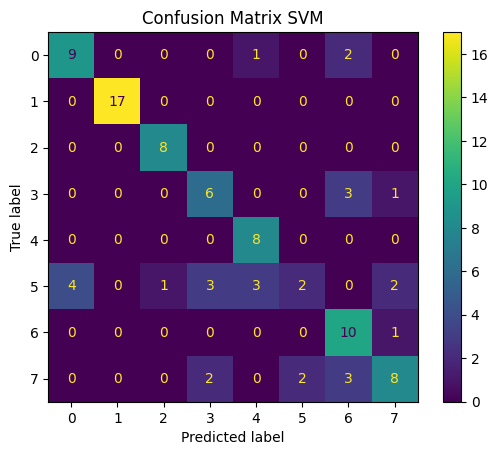

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_val_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix SVM')
plt.show()

In [29]:
print("Classification Report:\n", classification_report(y_test, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       1.00      1.00      1.00        17
           3       0.89      1.00      0.94         8
           4       0.55      0.60      0.57        10
           5       0.67      1.00      0.80         8
           6       0.50      0.13      0.21        15
           7       0.56      0.91      0.69        11
           8       0.67      0.53      0.59        15

    accuracy                           0.71        96
   macro avg       0.69      0.74      0.69        96
weighted avg       0.70      0.71      0.68        96



<div class="alert alert-block alert-success">
<b>Conclusion from fTDD+PCA+SVM:</b> <br>Ok! First step is always special. Final accuracy rate of 71% is pretty bad if you consider industry standard. But yes, it can be a good starting point.
</div>

<br>

#### 2c ii)Artificial Neural Network(ANN)

In [30]:
#The output is converted to categorical output as categorical_crossentropy is used as loss function

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [31]:
#Neural Network model is defined.

model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(9, activation="softmax"))

In [32]:
#The model is compiled
model.compile(loss='categorical_crossentropy', optimizer= 'adam', run_eagerly = True)

#Run the model
es = keras.callbacks.EarlyStopping(patience = 100, monitor='loss', verbose=4, restore_best_weights = True)
fit = model.fit(X_train, y_train, epochs=1000, batch_size = 4, callbacks = es)

Epoch 1/1000
96/96 [==============================] - 2s 21ms/step - loss: 10.6457
Epoch 2/1000
96/96 [==============================] - 2s 20ms/step - loss: 3.7143
Epoch 3/1000
96/96 [==============================] - 2s 21ms/step - loss: 3.6035
Epoch 4/1000
96/96 [==============================] - 2s 22ms/step - loss: 2.3824
Epoch 5/1000
96/96 [==============================] - 2s 22ms/step - loss: 1.6309
Epoch 6/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.5700
Epoch 7/1000
96/96 [==============================] - 2s 22ms/step - loss: 0.8616
Epoch 8/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.4269
Epoch 9/1000
96/96 [==============================] - 2s 21ms/step - loss: 0.8284
Epoch 10/1000
96/96 [==============================] - 2s 22ms/step - loss: 0.8206
Epoch 11/1000
96/96 [==============================] - 2s 22ms/step - loss: 0.7549
Epoch 12/1000
96/96 [==============================] - 2s 20ms/step - loss: 0.6786
Epoch 13/100

96/96 [==============================] - 2s 20ms/step - loss: 5.2453e-05
Epoch 97/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.6779e-05
Epoch 98/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.5186e-05
Epoch 99/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.8643e-05
Epoch 100/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.4642e-05
Epoch 101/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.0727e-05
Epoch 102/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.0055e-05
Epoch 103/1000
96/96 [==============================] - 2s 20ms/step - loss: 3.8528e-05
Epoch 104/1000
96/96 [==============================] - 2s 22ms/step - loss: 3.8177e-05
Epoch 105/1000
96/96 [==============================] - 2s 20ms/step - loss: 3.6327e-05
Epoch 106/1000
96/96 [==============================] - 2s 20ms/step - loss: 3.6759e-05
Epoch 107/1000
96/96 [============================

96/96 [==============================] - 2s 20ms/step - loss: 6.3640e-07
Epoch 190/1000
96/96 [==============================] - 2s 20ms/step - loss: 6.0287e-07
Epoch 191/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.8021e-07
Epoch 192/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.5320e-07
Epoch 193/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.3427e-07
Epoch 194/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.1657e-07
Epoch 195/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.8677e-07
Epoch 196/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.3865e-07
Epoch 197/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.3306e-07
Epoch 198/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.3555e-07
Epoch 199/1000
96/96 [==============================] - 2s 20ms/step - loss: 3.9519e-07
Epoch 200/1000
96/96 [=========================

96/96 [==============================] - 2s 20ms/step - loss: 9.3132e-09
Epoch 283/1000
96/96 [==============================] - 2s 20ms/step - loss: 7.7610e-09
Epoch 284/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.0245e-08
Epoch 285/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.3349e-08
Epoch 286/1000
96/96 [==============================] - 2s 20ms/step - loss: 8.0715e-09
Epoch 287/1000
96/96 [==============================] - 2s 20ms/step - loss: 7.7610e-09
Epoch 288/1000
96/96 [==============================] - 2s 20ms/step - loss: 8.6923e-09
Epoch 289/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.3406
Epoch 290/1000
96/96 [==============================] - 2s 20ms/step - loss: 6.0546
Epoch 291/1000
96/96 [==============================] - 2s 20ms/step - loss: 0.9540
Epoch 292/1000
96/96 [==============================] - 2s 20ms/step - loss: 0.3694
Epoch 293/1000
96/96 [==============================] - 2s 20ms

96/96 [==============================] - 2s 22ms/step - loss: 3.8772e-05
Epoch 377/1000
96/96 [==============================] - 2s 21ms/step - loss: 3.6569e-05
Epoch 378/1000
96/96 [==============================] - 2s 22ms/step - loss: 3.4648e-05
Epoch 379/1000
96/96 [==============================] - 2s 24ms/step - loss: 3.3386e-05
Epoch 380/1000
96/96 [==============================] - 2s 24ms/step - loss: 3.1134e-05
Epoch 381/1000
96/96 [==============================] - 2s 23ms/step - loss: 2.9569e-05
Epoch 382/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.7585e-05
Epoch 383/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.7002e-05
Epoch 384/1000
96/96 [==============================] - 2s 22ms/step - loss: 2.6785e-05
Epoch 385/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.4524e-05
Epoch 386/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.4418e-05
Epoch 387/1000
96/96 [=========================

In [33]:
#Predict the results of the data

y_test_ann = model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


In [34]:
#Convert the categorical data into the ouput class. Where the max probability is used as output.

y_pred_classes = np.argmax(y_test_ann, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

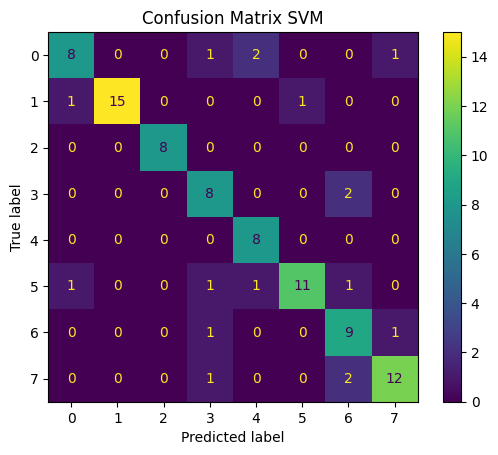

In [35]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix SVM')
plt.show()

In [36]:
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.67      0.73        12
           2       1.00      0.88      0.94        17
           3       1.00      1.00      1.00         8
           4       0.67      0.80      0.73        10
           5       0.73      1.00      0.84         8
           6       0.92      0.73      0.81        15
           7       0.64      0.82      0.72        11
           8       0.86      0.80      0.83        15

    accuracy                           0.82        96
   macro avg       0.83      0.84      0.82        96
weighted avg       0.84      0.82      0.83        96



<div class="alert alert-block alert-success">
<b>Conclusion from fTDD+PCA+ANN:</b> <br> Much much better. The same data when trained with a neural network gives a huge upgrade. Almost 11% increase in accuracy. 82% is not very bad as per industry standard of 90%. <br> In further studies, you can include a validation data and can also try other optimizer or loss function.
</div>

<br>

<br>

## 3. Algorithm TD_AR_Hjorth+LDA+SVM/ANN

In the second algorithm, the feature is extracted via the TD+AR+Hjorth. The code for this process is given in this github repo itself. The mathematical details of the procedure can be found [here](https://www.researchgate.net/publication/301519465_Finger_Movement_Pattern_Recognition_Method_Using_Artificial_Neural_Network_Based_on_Electromyography_EMG_Sensor?enrichId=rgreq-9d1c14eba0511abbc58c129656817f77-XXX&enrichSource=Y292ZXJQYWdlOzMwMTUxOTQ2NTtBUzozNTI4NzU4MDE3OTI1MTJAMTQ2MTE0MzU1NTE0Mg%3D%3D&el=1_x_3&_esc=publicationCoverPdf). After feature extraction, the feature is reduced via Linear Discriminant Analysis(LDA). Then it is trained via SVM and ANN.

<div class="alert alert-block alert-warning">
<b>TD+AR+Hjorth Feature extraction:</b> <br><br>
fTDD uses time domain features of the signal. This feature extraction procedure also uses few popular time domain features(9 time domain features) added with some Autoregressive coefficients(Here 4 coefficients are used) added with Hjorth parameters of activity, mobility and complexity. In total there are 16 features. The description of the features can be found from the research paper mentioned. We have used that paper as a reference to write the code for the functions.(Written in the 'feature_extraction_TD_AR_Hjorth_without_window.py' file ) <br><br>
Here no window is used. The whole 20000 signals of the channels are used to find 32 features(16 features per channel). Then the data is reduced to 7 in the LDA process, which projects the data in such axes that will help our classification algorithm. 
</div>

<div class="alert alert-block alert-info">
<b>Point to note:</b> <br>
The codes used here are already explained in the previous sections. So, we have not given any explanation of the matrix formed in this section. <br> <b>Running of this section of code will overwrite the data used in the previous sections. Change the names if required.</b> 
</div>

<br>

### 3a) TD+AR+Hjorth and preparation of the data

In [39]:
#This piece of block will create the data to train and feature extraction

X_data = np.zeros((480,32))
j = 0

for i in range(0,960,2):
    x = df.iloc[[i,i+1]]
    feat = feat_extract.features_estimation(x)
    X_data[j] = feat.flatten()
    j += 1
    

In [40]:
#This piece of block will fix the output data. 

y_data = []

for i in range(1,9):
    for j in range(0,60):
        y_data.append(i) 

y_data= np.array(y_data)

<br>

### 3b) Linear Dicrimnant Analysis(LDA)

In [42]:
#LDA is done after division of training and test set as LDA takes into account the output of the data also

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)

In [46]:
#Does the LDA. It fits on the training set and transforms the test set

lda = LinearDiscriminantAnalysis(n_components=7)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

<br>

### 3c) Classification Algorithms

#### 3c i) Support Vector Machines(SVM)

In [47]:
#Train on training data
svm = SVC()
svm.fit(X_train, y_train)

# Predict on validation data
y_val_pred = svm.predict(X_test)

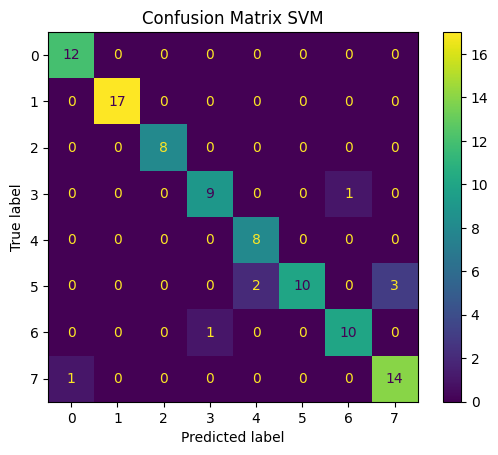

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_val_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix SVM')
plt.show()

In [50]:
print("Classification Report:\n", classification_report(y_test, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00         8
           4       0.90      0.90      0.90        10
           5       0.80      1.00      0.89         8
           6       1.00      0.67      0.80        15
           7       0.91      0.91      0.91        11
           8       0.82      0.93      0.88        15

    accuracy                           0.92        96
   macro avg       0.92      0.93      0.92        96
weighted avg       0.93      0.92      0.91        96



<div class="alert alert-block alert-success">
<b>Conclusion from TD_AR_Hjorth+LDA+SVM:</b> <br>Yes, it works just fine. 92% is better than the original research paper. Roughly, the research paper uses similar feature extraction but here no window is used. The research paper given at the start of the second algorithm uses without window and they achieved a highest of 96.7% but that is for 5 class classfication. <br> So, we can conclude that it is one of the best results possible on this dataset for 8 class classification.
</div>

<br>

#### 3c ii) Artificial Neural Network(ANN)

In [51]:
#The output is converted to categorical output as categorical_crossentropy is used as loss function

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [52]:
#Neural Network model is defined.

model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(9, activation="softmax"))

In [53]:
#The model is compiled
model.compile(loss='categorical_crossentropy', optimizer= 'adam', run_eagerly = True)

#Run the model
es = keras.callbacks.EarlyStopping(patience = 100, monitor='loss', verbose=4, restore_best_weights = True)
fit = model.fit(X_train, y_train, epochs=1000, batch_size = 4, callbacks = es)

Epoch 1/1000
96/96 [==============================] - 2s 24ms/step - loss: 0.8762
Epoch 2/1000
96/96 [==============================] - 2s 21ms/step - loss: 0.2717
Epoch 3/1000
96/96 [==============================] - 2s 22ms/step - loss: 0.2005
Epoch 4/1000
96/96 [==============================] - 2s 21ms/step - loss: 0.1524
Epoch 5/1000
96/96 [==============================] - 2s 23ms/step - loss: 0.1413
Epoch 6/1000
96/96 [==============================] - 2s 22ms/step - loss: 0.1245
Epoch 7/1000
96/96 [==============================] - 2s 22ms/step - loss: 0.1047
Epoch 8/1000
96/96 [==============================] - 2s 25ms/step - loss: 0.0831
Epoch 9/1000
96/96 [==============================] - 2s 23ms/step - loss: 0.0697
Epoch 10/1000
96/96 [==============================] - 2s 25ms/step - loss: 0.0671
Epoch 11/1000
96/96 [==============================] - 2s 26ms/step - loss: 0.0660
Epoch 12/1000
96/96 [==============================] - 3s 30ms/step - loss: 0.0479
Epoch 13/1000

96/96 [==============================] - 2s 21ms/step - loss: 3.2078e-05
Epoch 98/1000
96/96 [==============================] - 2s 25ms/step - loss: 2.9736e-05
Epoch 99/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.7398e-05
Epoch 100/1000
96/96 [==============================] - 2s 22ms/step - loss: 2.6490e-05
Epoch 101/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.5220e-05
Epoch 102/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.3337e-05
Epoch 103/1000
96/96 [==============================] - 2s 23ms/step - loss: 2.2178e-05
Epoch 104/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.1090e-05
Epoch 105/1000
96/96 [==============================] - 2s 21ms/step - loss: 2.0011e-05
Epoch 106/1000
96/96 [==============================] - 2s 22ms/step - loss: 1.8343e-05
Epoch 107/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.7369e-05
Epoch 108/1000
96/96 [===========================

96/96 [==============================] - 2s 21ms/step - loss: 1.8502e-07
Epoch 191/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.7726e-07
Epoch 192/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.7012e-07
Epoch 193/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.5398e-07
Epoch 194/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.5087e-07
Epoch 195/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.4032e-07
Epoch 196/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.3815e-07
Epoch 197/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.2790e-07
Epoch 198/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.2014e-07
Epoch 199/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.1859e-07
Epoch 200/1000
96/96 [==============================] - 2s 21ms/step - loss: 1.1424e-07
Epoch 201/1000
96/96 [=========================

96/96 [==============================] - 2s 20ms/step - loss: 2.4835e-09
Epoch 284/1000
96/96 [==============================] - 2s 20ms/step - loss: 3.4148e-09
Epoch 285/1000
96/96 [==============================] - 2s 20ms/step - loss: 2.4835e-09
Epoch 286/1000
96/96 [==============================] - 2s 20ms/step - loss: 2.1731e-09
Epoch 287/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.2418e-09
Epoch 288/1000
96/96 [==============================] - 2s 20ms/step - loss: 2.4835e-09
Epoch 289/1000
96/96 [==============================] - 2s 20ms/step - loss: 2.1731e-09
Epoch 290/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.5522e-09
Epoch 291/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.8626e-09
Epoch 292/1000
96/96 [==============================] - 2s 20ms/step - loss: 2.1731e-09
Epoch 293/1000
96/96 [==============================] - 2s 20ms/step - loss: 1.2418e-09
Epoch 294/1000
96/96 [=========================

96/96 [==============================] - 2s 20ms/step - loss: 5.8036e-06
Epoch 377/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.6379e-06
Epoch 378/1000
96/96 [==============================] - 2s 22ms/step - loss: 5.4660e-06
Epoch 379/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.3133e-06
Epoch 380/1000
96/96 [==============================] - 2s 20ms/step - loss: 5.1668e-06
Epoch 381/1000
96/96 [==============================] - 2s 21ms/step - loss: 5.0160e-06
Epoch 382/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.8819e-06
Epoch 383/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.7516e-06
Epoch 384/1000
96/96 [==============================] - 2s 21ms/step - loss: 4.6228e-06
Epoch 385/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.5101e-06
Epoch 386/1000
96/96 [==============================] - 2s 20ms/step - loss: 4.3873e-06
Epoch 387/1000
96/96 [=========================

In [54]:
#Predict the results of the data

y_test_ann = model.predict(X_test)

3/3 [==============================] - 0s 9ms/step


In [55]:
#Convert the categorical data into the ouput class. Where the max probability is used as output.

y_pred_classes = np.argmax(y_test_ann, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

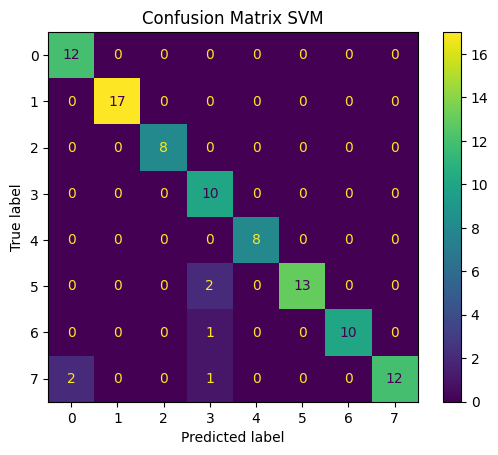

In [56]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix SVM')
plt.show()

In [57]:
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00         8
           4       0.71      1.00      0.83        10
           5       1.00      1.00      1.00         8
           6       1.00      0.87      0.93        15
           7       1.00      0.91      0.95        11
           8       1.00      0.80      0.89        15

    accuracy                           0.94        96
   macro avg       0.95      0.95      0.94        96
weighted avg       0.95      0.94      0.94        96



<div class="alert alert-block alert-success">
<b>Conclusion from TD_AR_Hjorth+LDA+ANN:</b> <br>This is the best model trained by us. 94% is very good with respect to industry standard. Future scope may include extracting feature from the frequency domain features or maybe Frequency-Time domain features(Wavelet Transform). <a href="https://arxiv.org/pdf/2107.00733">Here</a> is a research paper that used wavelet transform on this dataset and achieved 95% acuuracy. 
    
<b> With all that said, this is one of the best algorithm that can be used for this dataset. Again, This may not work very well for other EMG dataset. Remember there is no golden rule. But the idea presented in this type of analysis is universal.</b>
<span style="font-size: 20px;">&#9786;</span>
</div>

<br>

<br>